In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from typing import *
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import math 
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution
from torch.distributions import Bernoulli
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce

from tqdm import tqdm

from plotting import make_vae_plots

CMNIST_list = torch.load("data/ColoredMNIST/train1.pt")
CMNIST = pd.DataFrame(CMNIST_list, columns = ["image", "label"])

images = CMNIST.iloc[:,0]
labels_df = CMNIST.iloc[:,1]
labels = torch.tensor(labels_df)

c:\Users\Peetz\miniconda3\envs\02456\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision.transforms import ToTensor
transform_to_tensor = ToTensor()
transform_to_tensor(images[0]).shape

torch.Size([3, 28, 28])

# Create synthetic data

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
from torch.distributions import Distribution
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

In [4]:
class SynthNN(nn.Module):
    def __init__(self, hidden_size = 6):
        super().__init__()
        self.function = nn.Sequential(
            nn.Linear(in_features=2, out_features=hidden_size),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=10),
        )
    def forward(self, Z):
        return self.function(Z)


def simulate_synthetic_data(samples, function):
    envs1 = np.array([0.2, 2, 3, 5])
    E = np.random.choice([0,1,2,3], size = samples)

    env = envs1[E]
    Z1 = env + np.random.normal(0, 1, size = samples)
    Z2 = 2*env + np.random.normal(0, np.sqrt(2), size = samples)
    Y = Z1 + Z2 + np.random.normal(0, 1, size = samples)
    # Z3 = Y + env + np.random.normal(0, 1, size = samples)
    Z = np.stack([Z1, Z2], axis = 1) # Add Z3 if need be. 

    if function == 'identity':
        X = Z
    elif function == 'linear':
        S = np.random.normal(size = (2,10))
        X = Z@S
    elif function == 'nonlinear':
        synthnn = SynthNN()
        X = synthnn(torch.tensor(Z).float()).detach().numpy()
    
    return X, Y, E, Z, env

class EnvDataset(Dataset):
    def __init__(self, X, Y, E):
        super().__init__()
        self.X = torch.tensor(X)
        self.Y = torch.tensor(Y).unsqueeze(1)
        E = torch.tensor(E) #From Peter
        # self.E = torch.nn.functional.one_hot(torch.tensor(E))
        self.E = torch.nn.functional.one_hot(E.long())
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index], self.E[index] 
    
    def __len__(self):
        return(len(self.X))
        
model = SynthNN()
#x, y, e, z, env = simulate_synthetic_data(100, "nonlinear")

In [5]:
#Generate data
#torch.manual_seed(1)
X, Y, envs, Z, E = simulate_synthetic_data(8000, 'nonlinear')
dset1 = EnvDataset(X[:4000],Y[:4000],envs[:4000])
train_loader = DataLoader(dset1, batch_size=128)


dset2 = EnvDataset(X[4000:],Y[4000:],envs[4000:])
test_loader = DataLoader(dset2, batch_size=128)

#test = next(iter(train_loader))
#print(test[2])


# Load a batch of images into memory
sample = next(iter(train_loader))
images = sample[0]
label = sample[1]
environment = sample[2]

## Plotting base distribution of data

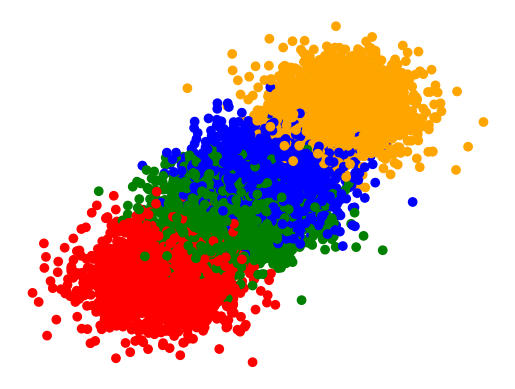

In [6]:
colorDF = pd.DataFrame(E)
cDF = colorDF.value_counts().rename_axis('unique_values').reset_index(name='counts')
cDF =cDF.sort_values("unique_values").reset_index()
colors = []

for col in E:
    if col == cDF["unique_values"][0]:
        colors.append("red")
    elif col == cDF["unique_values"][1]:
        colors.append("green")
    elif col == cDF["unique_values"][2]:
        colors.append("blue")
    elif col == cDF["unique_values"][3]:
        colors.append("orange")

# Plotting base data
orgFrame = pd.DataFrame(Z)
plt.axis('off')
# plt.scatter(orgFrame[0],orgFrame[1], orgFrame[2], c = colors).set_alpha(1)
plt.scatter(orgFrame[0],orgFrame[1], c = colors).set_alpha(1) # Plotting w/ only two parents. 

In [7]:
orgFrame.shape

(8000, 2)

# Copied from exercises and adjusted to our dataset:

In [8]:
p = Bernoulli(logits=torch.zeros((1000,)))


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    #def sample_epsilon(self) -> Tensor:
    #    """`\eps ~ N(0, I)`"""
    #    return torch.empty_like(self.mu).normal_()
        
    #def sample(self) -> Tensor:
    #    """sample `z ~ N(z | mu, sigma)` (without gradients)"""
    #    with torch.no_grad():
    #        return self.rsample()
        
    #def rsample(self) -> Tensor:
    #    """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
    #    self.z = torch.distributions.Normal(self.mu, self.sigma)
    #    return self.z.rsample() # <- your code
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        eps = torch.empty_like(self.mu).normal_()
        return self.mu + self.sigma * eps
    # <- your code    
        #return self.mu + self.sigma * self.sample_epsilon() # <- your code    
    
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return - ((z - self.mu)**2)/(2*self.sigma**2) - torch.log(self.sigma) - math.log(math.sqrt(2 * math.pi)) # <- your code
    
    #def log_prob(self, z:Tensor) -> Tensor:
    #    """return the log probability: log `p(z)`"""
    #    dummy = self.rsample()
    #    return self.z.log_prob(z) # <- your code

# VAE

In [9]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=2*latent_features),
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=10),

        )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_mean = self.decoder(z)
        px_mean = px_mean.view(-1, *self.input_shape) # reshape the output
        return torch.distributions.Normal(loc=px_mean, scale=0.1*torch.ones(px_mean.shape))
        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}


latent_features = 2
vae = VariationalAutoencoder(images[0].shape, latent_features)
print(vae)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=10, bias=True)
  )
)


# ELBO

In [10]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        #The input model in our case is the VAE and the x:tensor is our images.
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x)) #log(p(x|z)): Sandsynligheden for at observere vores input variabel x
        #givet vores latent space (tjekker modellens evne til at rekonstruere sig selv, ved at maximere sandsynlig-
        #heden for at observere inputtet selv, givet det konstruerede latent space.
        log_pz = reduce(pz.log_prob(z)) #log(p(z)): Sandsynligheden for at observere vores latent space, givet at
        #latent space følger en standard-normal fordeling (Jo højere sandsynlighed jo bedre)
        log_qz = reduce(qz.log_prob(z)) #log(q(z|x)): Sandsynligheden for at generere netop dette latent space givet 
        #vores input billede x. Denne værdi skal helst være lav?
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        #########################################################################################################
        # Reconstruction loss: E_q [ log p(x|z) ]
        # Regularization term: \beta * D_KL(q(z|x) | p(z))` => Forsøger at tvinge fordelingen q(z|x) mod N(0,1)?
        #########################################################################################################
        kl = log_qz - log_pz
        elbo = log_px - kl
        beta_elbo = log_px - self.beta * kl
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs
        

In [11]:
vi = VariationalInference(beta=1)
loss, diagnostics, outputs = vi(vae, images)
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

loss   | mean =    443.571, shape: []
elbo   | mean =   -443.571, shape: [128]
log_px | mean =   -443.051, shape: [128]
kl     | mean =      0.519, shape: [128]


# Initialization

In [12]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
latent_features = 2 #Hyper parameter
vae = VariationalAutoencoder(images[0].shape, latent_features)

# Evaluator: Variational Inference
beta = 1 #Hyper parameter
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3) #Hyper parameter, tilføj evt. weight_decay (L2 regularization)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

### Better implementation

In [13]:
torch.manual_seed(1)
num_epochs = 1000 #hyper parametre
#batch size hyper parameter can be changed in the dataloader in the beginning.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)

# training..
for i in tqdm(range(num_epochs)):
    epoch+= 1
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for sample in train_loader:
        x = images
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        sample = next(iter(test_loader))
        x = images
        y = label
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
        
        """
            Debugging variables
        """
        #print(training_data['elbo'][epoch-1])

>> Using device: cpu


100%|██████████| 1000/1000 [02:34<00:00,  6.47it/s]


# Phase 2 - PC algorithm based on latent variable

(page 6-7)

In [14]:
#Dummy code for the testing of the PC algorithm to ensure the model data is prepared in the right format
import numpy as np
import pandas as pd
import cdt
cdt.SETTINGS.rpath = r'C:\Program Files\R\R-4.2.2\bin/Rscript' # this path should point to your own R implementation !
from cdt.causality.graph import PC
import networkx as nx
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

#names = np.array(["A","B", "C", "D", "E"])
#data_df = pd.DataFrame(data, columns = names)
#pc_test = PC(CItest = 'gaussian', alpha = 0.05, verbose=False).create_graph_from_data(data_df[names[permutation]])

#nx.draw(pc_test, with_labels=True, font_weight='bold')
#plt.show()

#X, Y, envs
#cmnist = ConcatDataset([X, Y, E])
#loader = DataLoader(cmnist, batch_size = 8000, batch_sampler = None)
#dset = EnvDataset(X[:4000],Y[:4000],envs[:4000])
#loader = DataLoader(dset, batch_size=4000, drop_last=True)
loader = DataLoader(dset1, batch_size=4000)
sample = next(iter(loader))

x = sample[0]
y = sample[1]#.reshape(-1,1)
e = sample[2]#.reshape(-1,1)

# output = vae.forward(x.float(), y.float(), e.float())
qz = vae.posterior(x)
z = qz.rsample()

# z = output['z']

z_full = z
x_full = x
y_full = y
e_full = e

enviro = np.zeros((len(e),1))
for i in range(0,4):
    inde = e[:,i] == 1
    enviro[inde] = i+1

z_df = pd.DataFrame(z.detach())
y_df = pd.DataFrame(y.detach())
e_df = pd.DataFrame(enviro)

df = z_df; df['Y'] = y_df; 
#df_e['E'] = e_df

df.head(3)

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


,0,1,Y
0,-0.450354,-0.327602,9.510728
1,-0.239658,-0.074598,7.077905
2,1.304745,-1.174286,-2.997405


Fixing the column ordering so that Y is the first column

In [15]:
df.insert(0, 'Y', df.pop('Y'))
df.head(3)

,Y,0,1
0,9.510728,-0.450354,-0.327602
1,7.077905,-0.239658,-0.074598
2,-2.997405,1.304745,-1.174286


In [16]:

df.columns = ['Y','Z1', 'Z2']
df.head()

,Y,Z1,Z2
0,9.510728,-0.450354,-0.327602
1,7.077905,-0.239658,-0.074598
2,-2.997405,1.304745,-1.174286
3,4.034625,0.211808,0.362539
4,4.424482,0.178954,0.739100


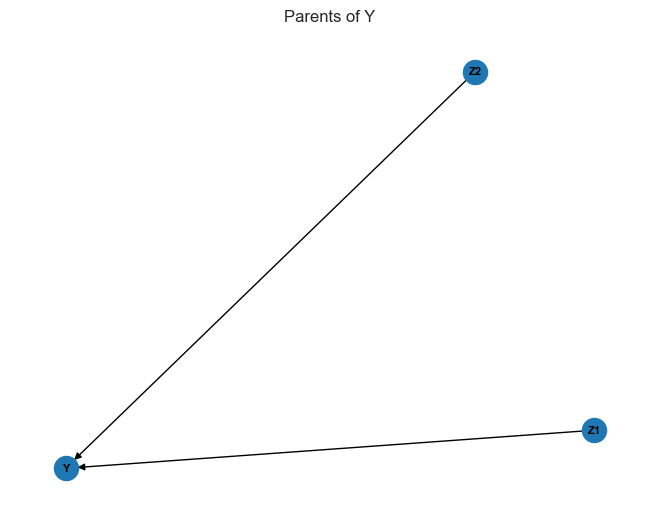

<Figure size 640x480 with 0 Axes>

In [17]:
pc = PC(alpha = 0.001)
pc_output = pc.predict(df)

nx.draw(pc_output, with_labels=True, font_weight='bold', font_size = 8)
plt.title("Parents of Y")
plt.show()
plt.savefig('Z1Z2_VAE_Parents_alpha001.png', transparent=True)

# Plotting based on dset 2

In [18]:
loader = DataLoader(dset2, batch_size=4000)
sample = next(iter(loader))

x2 = sample[0]
y2 = sample[1]#.reshape(-1,1)
e2 = sample[2]#.reshape(-1,1)

# output = vae.forward(x.float(), y.float(), e.float())
qz2 = vae.posterior(x)
z2 = qz2.rsample()

# z = output['z']

z_full2 = z2
x_full2 = x2
y_full2 = y2
e_full2 = e2

enviro2 = np.zeros((len(e2),1))
for i in range(0,4):
    inde = e2[:,i] == 1
    enviro2[inde] = i+1

z_df2 = pd.DataFrame(z2.detach())
y_df2 = pd.DataFrame(y2.detach())
e_df2 = pd.DataFrame(enviro2)

df2 = z_df2; df2['Y'] = y_df2; 
#df_e['E'] = e_df
df2.insert(0, 'Y', df2.pop('Y')) # Transfers value of column to columned index 0. 

df2.columns = ['Y','Z1', 'Z2']

df2.head(3)

,Y,Z1,Z2
0,9.278949,-0.363151,-0.290666
1,0.341949,-0.339758,-0.164482
2,4.453331,1.284176,-1.002754


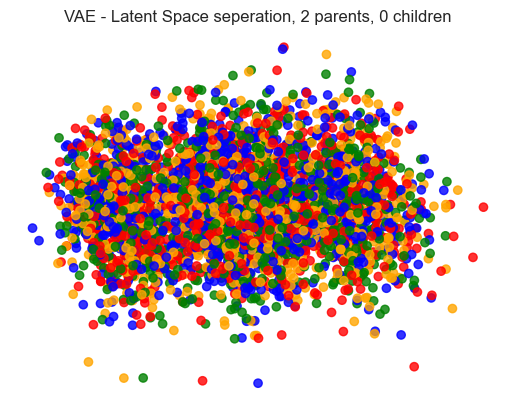

In [19]:
colors2 = []

for col in e_df2[0]:

    if col == (1.0):

        colors2.append("red")

    elif col == (2.0):

        colors2.append("green")

    elif col == (3.0):

        colors2.append("blue")

    elif col == (4.0):

        colors2.append("orange")



df2["colour"] = colors2




plt.scatter(df2["Z1"], df2["Z2"], c=df2["colour"]).set_alpha(0.8)
plt.title("VAE - Latent Space seperation, 2 parents, 0 children")
plt.axis("off")
plt.savefig('Z1Z2_VAE.png', transparent=True)